In [1]:
from math import *
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json

import matplotlib.pyplot as plt

import skyfield
from skyfield.api import load
from skyfield.api import N, W, S, E, wgs84
from skyfield.api import Star
from skyfield.data import hipparcos
from skyfield.almanac import find_discrete, risings_and_settings

In [2]:
ts = load.timescale()
eph = load('de421.bsp')

sun = eph['sun']
earth = eph['earth']
mars = eph['mars']
jupiter = eph['JUPITER BARYCENTER']
moon = eph['moon']

with load.open(hipparcos.URL) as f:
    stars_df = hipparcos.load_dataframe(f)
    
star_dictionary = {"Alpheratz":677, "Ankaa":2081, "Schedar":3179, "Diphda":3419, "Achernar":7588, "Hamal":9884, "Polaris":11767, "Acamar":13847, "Menkar":14135, "Mirfak":15863, "Aldebaran":21421, "Rigel":24436, "Capella":24608, "Bellatrix":25336, "Elnath":25428, "Alnilam":26311, "Betelgeuse":27989, "Canopus":30438, "Sirius":32349, "Adhara":33579, "Procyon":37279, "Pollux":37826, "Avior":41037, "Suhail":44816, "Miaplacidus":45238, "Alphard":46390, "Regulus":49669, "Dubhe":54061, "Denebola":57632, "Gienah":59803, "Acrux":60718, "Gacrux":61084, "Alioth":62956, "Spica":65474, "Alkaid":67301, "Hadar":68702, "Menkent":68933, "Arcturus":69673, "Rigil Kent.":71683, "Kochab":72607, "Zuben'ubi":72622, "Alphecca":76267, "Antares":80763, "Atria":82273, "Sabik":84012, "Shaula":85927, "Rasalhague":86032, "Eltanin":87833, "Kaus Aust.":90185, "Vega":91262, "Nunki":92855, "Altair":97649, "Peacock":100751, "Deneb":102098, "Enif":107315, "Al Na'ir":109268, "Fomalhaut":113368, "Scheat":113881, "Markab":113963}

In [3]:
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/index.html

# Constants
k = 0.01720209895
KM_IN_AU = 149600000
KG_IN_SOLAR_MASS = 1.989 * pow(10, 30)

# Masses
SUN_MASS_KG = KG_IN_SOLAR_MASS
EARTH_MASS_KG = 5.97 * pow(10,24)
MARS_MASS_KG = 0.642 * pow(10,24)
JUPITER_MASS_KG = 1898 * pow(10,24)
MOON_MASS_KG = 0.073 * pow(10,24)

SUN_MASS = 1.0
EARTH_MASS = EARTH_MASS_KG / KG_IN_SOLAR_MASS
MARS_MASS = MARS_MASS_KG / KG_IN_SOLAR_MASS
JUPITER_MASS = JUPITER_MASS_KG / KG_IN_SOLAR_MASS
MOON_MASS = MOON_MASS_KG / KG_IN_SOLAR_MASS

# Distances
EARTH_SUN_DIST_KM = 149.6 * pow(10, 6)
MARS_SUN_DIST_KM = 228.0 * pow(10, 6) 
JUPITER_SUN_DIST_KM = 778.5 * pow(10, 6)
MOON_EARTH_DIST_KM = 0.384 * pow(10, 6) 

EARTH_SUN_DIST = EARTH_SUN_DIST_KM / KM_IN_AU
MARS_SUN_DIST = MARS_SUN_DIST_KM / KM_IN_AU
JUPITER_SUN_DIST = JUPITER_SUN_DIST_KM / KM_IN_AU
MOON_EARTH_DIST = MOON_EARTH_DIST_KM / KM_IN_AU

# Orbital Periods (in days)
EARTH_ORBITIAL_PERIOD = 365.2
MARS_ORBITIAL_PERIOD = 687
JUPITER_ORBITIAL_PERIOD = 4331
MOON_ORBITAL_PERIOD = 27.3

# Orbital Eccentricity
EARTH_ECCENTYICITY = 0.017
MARS_ECCENTYICITY = 0.094
JUPITER_ECCENTYICITY = 0.049
MOON_ECCENTYICITY = 0.055

# Kepler 1st Law

Generate a few orbits using Skyfield, and observe the ellipitical properities of the output.

In [4]:
# Skyfield plots position with some degree Z... to reduce to a plane need to rotate abot the X axis

earthRotation = -23.44
marsRotation = -24.64
jupiterRotation = -23.21
moonRotation = -25.96

def Rx(theta):
    return np.matrix([[ 1, 0 , 0],
                   [ 0, cos(theta),-sin(theta)],
                   [ 0, sin(theta), cos(theta)]])

In [5]:
def generateOrbitData(refBody, orbitBody, orbitStart, orbitalPeriod, rotX):
    timeStart = ts.ut1(orbitStart.year, orbitStart.month, orbitStart.day)
    orbitEnd = orbitStart + timedelta(hours = ceil(orbitalPeriod*24))
    timeEnd = ts.ut1(orbitEnd.year, orbitEnd.month, orbitEnd.day)
    
    samples = ceil(orbitalPeriod * 24) # sample at every 2 hours
    sampleTimes = ts.linspace(timeStart, timeEnd, num=samples)
    positions = np.zeros((samples, 3))
    distances = np.zeros((samples))
    
    for idx, time in enumerate(sampleTimes):
        position = refBody.at(time).observe(orbitBody)
        positions[idx] = position.xyz.au
        distances[idx] = position.distance().au
        
    z = positions[:,2]
    zRange = z.max()-z.min()
    print(zRange)
    
    # TODO Calculate the correct rotation
    rotationMatrix = Rx(radians(rotX))    
    positionsRotated = np.asarray(rotationMatrix.dot(positions.T).T)
    
    x = positionsRotated[:,0]
    y = positionsRotated[:,1]
    z = positionsRotated[:,2]
    print(z.max() - z.min())
    
    a = (x.max() - x.min())/2
    b = (y.max() - y.min())/2
    c = sqrt(abs(pow(a,2)-pow(b,2)))
    e = c/a
    
    return x, y, c, e, distances.mean()

In [6]:
# Generate and observe orbit data.

dt = datetime(2022, 1, 1, 0, 0, 0)

xMoon, yMoon, cMoon, eMoon, distMoon = generateOrbitData(earth, moon, dt, MOON_ORBITAL_PERIOD, moonRotation)
xEarth, yEarth, cEarth, eEarth, distEarth = generateOrbitData(sun, earth, dt, EARTH_ORBITIAL_PERIOD, earthRotation)
xMars, yMars, cMars, eMars, distMars = generateOrbitData(sun, mars, dt, MARS_ORBITIAL_PERIOD, marsRotation)
xJupiter, yJupiter, cJupiter, eJupiter, distJupiter = generateOrbitData(sun, jupiter, dt, JUPITER_ORBITIAL_PERIOD, jupiterRotation)



0.0022606595753566494
0.00039716190856829643
0.7954782233454409
0.00013257259319223076
1.2679283207533518
0.07465403847792935
4.100671337773979
0.23272254636183926


Earth: dist: 1.000151627728182; e: 0.01792541036000108
Mars: dist: 1.5303051978176965; e: 0.071323916038034
Jupiter: dist: 5.209068802986188; e: 0.03521799982909289
Moon: dist: 0.0025788538141357834; e: 0.13701127968832527


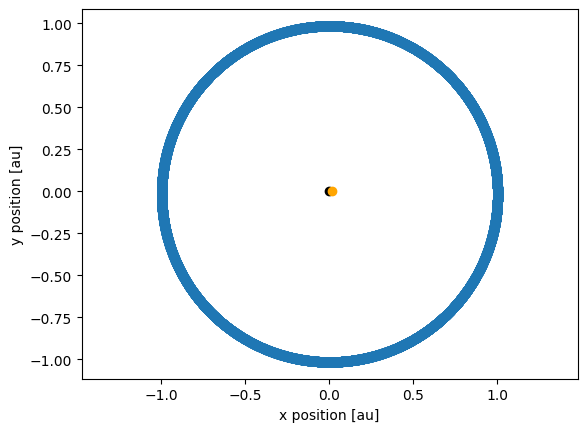

In [7]:
print("Earth: dist: {}; e: {}".format(distEarth, eEarth))
print("Mars: dist: {}; e: {}".format(distMars, eMars))
print("Jupiter: dist: {}; e: {}".format(distJupiter, eJupiter))
print("Moon: dist: {}; e: {}".format(distMoon, eMoon))

plt.scatter(0,0, color='black') # true center
plt.scatter(cEarth,0, color='orange') # refBody position at one of the foci (c)
plt.scatter(xEarth,yEarth)
plt.axis('equal')
plt.xlabel('x position [au]')
plt.ylabel('y position [au]')
plt.show()

# Kepler 3rd Law

Use Kepler's Third Law to explore the relationship between orbital period and distance

In [8]:
def orbitalPeriod (distAU, mass1, mass2):
    return sqrt((4*pow(pi,2))/(pow(k,2)*(mass1+mass2)) * pow(distAU, 3))

In [9]:
# Use Constants
print("Earth: {} au. P = {}".format(EARTH_SUN_DIST, orbitalPeriod(EARTH_SUN_DIST, SUN_MASS, EARTH_MASS)))
print("Mars: {} au.  P = {}".format(MARS_SUN_DIST, orbitalPeriod(MARS_SUN_DIST, SUN_MASS, MARS_MASS)))
print("Jupiter: {} au.  P = {}".format(JUPITER_SUN_DIST, orbitalPeriod(JUPITER_SUN_DIST, SUN_MASS, JUPITER_MASS)))
print("Moon: {} au.  P = {}".format(MOON_EARTH_DIST, orbitalPeriod(MOON_EARTH_DIST, EARTH_MASS, MOON_MASS)))




Earth: 1.0 au. P = 365.25635016675693
Mars: 1.5240641711229947 au.  P = 687.2317838065143
Jupiter: 5.203877005347594 au.  P = 4333.92955948361
Moon: 0.0025668449197860962 au.  P = 27.251409358962366


In [10]:
# Use Skyfield generated data
print("Earth: {} au. P = {}".format(distEarth, orbitalPeriod(distEarth, SUN_MASS, EARTH_MASS)))
print("Mars: {} au.  P = {}".format(distMars, orbitalPeriod(distMars, SUN_MASS, MARS_MASS)))
print("Jupiter: {} au.  P = {}".format(distJupiter, orbitalPeriod(distJupiter, SUN_MASS, JUPITER_MASS)))
print("Moon: {} au.  P = {}".format(distMoon, orbitalPeriod(distMoon, EARTH_MASS, MOON_MASS)))


Earth: 1.000151627728182 au. P = 365.3394278016459
Mars: 1.5303051978176965 au.  P = 691.4574127686532
Jupiter: 5.209068802986188 au.  P = 4340.416981206117
Moon: 0.0025788538141357834 au.  P = 27.44287501581148
